# Introduction To Machine Learning: linear classification with SVM
In this notebook, we shall use the usps dataset and differentiate between the grayscale digits 1 and 5

# Imports

In [1]:
# the warning wrapper is to avoid an annoying warning of h5py
import warnings
import h5py
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import svm

### Load the usps dataset
Grayscale 16x16 digits.
already scaled to 0-1 range (instead of 0-255).

In [2]:
def hdf5(path, data_key = "data", target_key = "target", flatten = True):
    """
        loads data from hdf5:
        - hdf5 should have 'train' and 'test' groups
        - each group should have 'data' and 'target' dataset or spcify the key
        - flatten means to flatten images N * (C * H * W) as N * D array
    """
    with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_train = train.get(data_key)[:]
        y_train = train.get(target_key)[:]
        test = hf.get('test')
        X_test = test.get(data_key)[:]
        y_test = test.get(target_key)[:]
        if flatten:
            X_train = X_train.reshape(X_train.shape[0], reduce(lambda a, b: a * b, X_train.shape[1:]))
            X_test = X_test.reshape(X_test.shape[0], reduce(lambda a, b: a * b, X_test.shape[1:]))
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = hdf5("usps.h5")
print("Dataset loaded. Train shape: "+str(X_train.shape)+". Test shape: "+str(X_test.shape)+".")

Dataset loaded. Train shape: (7291, 256). Test shape: (2007, 256).


### View some samples

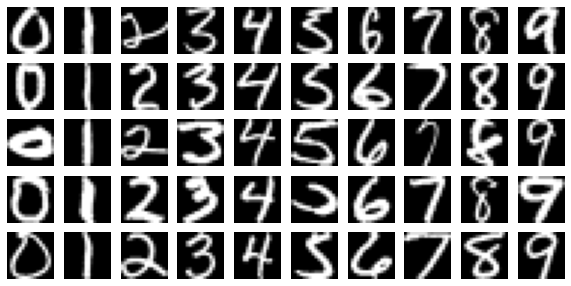

In [3]:
num_samples = 5
num_classes = len(set(y_train))

classes = set(y_train)
num_classes = len(classes)
fig, ax = plt.subplots(num_samples, num_classes, sharex = True, sharey = True, figsize=(num_classes, num_samples))

for label in range(num_classes):
    class_idxs = np.where(y_train == label)
    for i, idx in enumerate(np.random.randint(0, class_idxs[0].shape[0], num_samples)):
        # the imshow with 'gray' option, recieves either 0-255 integers, or 0-1 floats.
        ax[i, label].imshow(X_train[class_idxs[0][idx]].reshape([16, 16]), 'gray')
        ax[i, label].set_axis_off()
plt.show()

# Preprocessing
The input dimension is too big!

Regression models will use 257 weights (256 pixel + bias).
Lets reduce the input dimension to 2: Symmetry, and intensity.

In [4]:
def symmetry(image):
    im = image.reshape((16,16))
    return np.mean(1-np.abs(im - im[::-1,:]))
def intensity(image):
    return np.mean(image)
X_train_pro = np.array([np.array([intensity(im),symmetry(im)]) for im in X_train])

print('Done preprocessing. New shape: ', X_train_pro.shape)

Done preprocessing. New shape:  (7291, 2)


### Take only 5 and 1 digits

In [5]:
X_train_1, X_train_pro_1 = X_train[y_train == 1], X_train_pro[y_train == 1]
X_train_5, X_train_pro_5 = X_train[y_train == 5], X_train_pro[y_train == 5]

### Plot

## Linear \ Logistic Regression

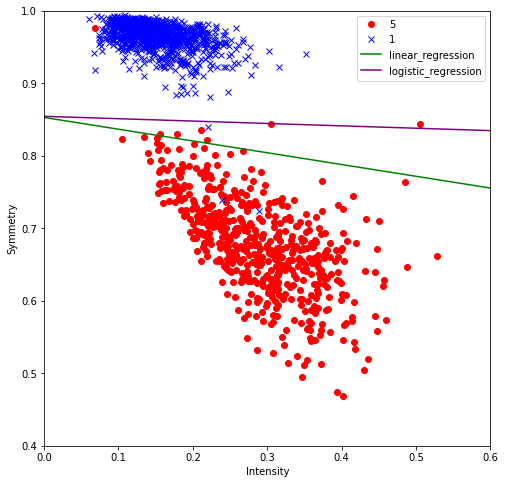

In [30]:
X = np.concatenate([X_train_pro_1,X_train_pro_5])
y = np.ones(X.shape[0])


# train linear regression
y[-X_train_pro_5.shape[0]:] = -1
regr = LinearRegression().fit(X, y)
a,b = -regr.intercept_/regr.coef_[1], -regr.intercept_/regr.coef_[0]

# train logistic regression
y[-X_train_pro_5.shape[0]:] = 0
log_reg = LogisticRegression(C=1000).fit(X, y)
log_a,log_b = -log_reg.intercept_[0]/log_reg.coef_[0][1], -log_reg.intercept_[0]/log_reg.coef_[0][0]

#plot
plt.figure(figsize=(8,8))
plt.plot([im[0] for im in X_train_pro_5],[im[1] for im in X_train_pro_5],'ro',label='5')
plt.plot([im[0] for im in X_train_pro_1],[im[1] for im in X_train_pro_1],'bx',label='1')
plt.plot([0,b],[a,0],'green',label='linear_regression')
plt.plot(np.array([0,log_b]),np.array([log_a,0]),'purple',label='logistic_regression')
plt.ylim(0.4,1) # since there arent any sample with lower symmetry
plt.xlim(0,0.6) # since there arent any sample with higher Intensity
plt.xlabel('Intensity')
plt.ylabel('Symmetry')
plt.legend(numpoints=1)
plt.show()

## SVM

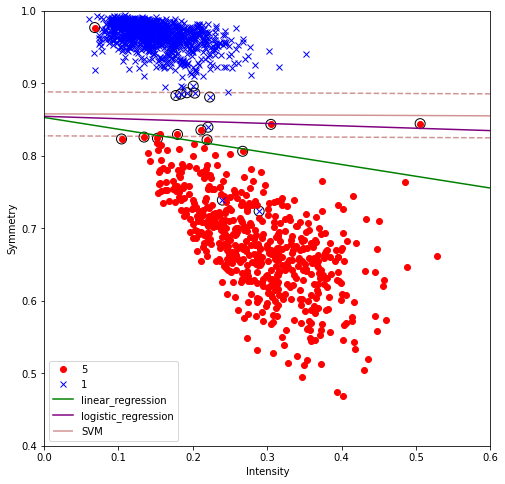

In [31]:
# fit the model
clf = svm.SVC(kernel='linear', C=10000000)
clf.fit(X, y)
#plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
plt.figure(figsize=(8,8))
plt.plot([im[0] for im in X_train_pro_5],[im[1] for im in X_train_pro_5],'ro',label='5')
plt.plot([im[0] for im in X_train_pro_1],[im[1] for im in X_train_pro_1],'bx',label='1')

# plot the decision function
ax = plt.gca()
xlim = (0,0.6)
ylim = (0.4,1)

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    contour = ax.contour(XX, YY, Z, colors='brown', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    contour.collections[1].set_label('SVM')

# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,linewidth=1, facecolors='none', edgecolors='k')

plt.plot([0,b],[a,0],'green',label='linear_regression')
plt.plot([0,log_b],[log_a,0],'purple',label='logistic_regression')
plt.xlim(0,0.6)
plt.ylim(0.4,1)
plt.xlabel('Intensity')
plt.ylabel('Symmetry')
plt.legend(numpoints=1, loc='lower left')
plt.show()

The right most support vector really impacts the model when the C parameter is large. Try to reduce the regularization term and see how the ouput classifier allows more violations and changes!